<a href="https://colab.research.google.com/github/heokwon/Survey-analysis/blob/main/Cafeteria_Survey/Survey_TopicModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install konlpy
!pip install wordcloud

!pip install pyLDAvis

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 60.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=cd4572c9b753926d48900928f16e03b2f983233efb22e19d0a518fd17000e2f5
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=9e26be1

In [ ]:
import pickle

In [ ]:
import nltk
from nltk.util import ngrams
from nltk import word_tokenize
from nltk import ConditionalFreqDist
from nltk.probability import ConditionalProbDist, MLEProbDist
import numpy as np
import codecs
from tqdm import tqdm
import random

In [ ]:
import numpy as np
import re
import pandas as pd
from konlpy.tag import Okt
from future.utils import iteritems
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
import seaborn as sns
from wordcloud import WordCloud
import pyLDAvis.gensim_models
# 브라우저에서 바로 그려지도록 
# %matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# # Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumSquareRound') 

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

# Seaborn 테마 설정
sns.set_theme(style="ticks", color_codes=True, font='NanumSquareRound', font_scale=2)

# 워닝 메세지 삭제
import warnings
warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [ ]:
import gensim
import numpy as np
import spacy

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary

In [ ]:
## font 경로설정
font_list = [font.name for font in fm.fontManager.ttflist]
font_list
font_path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'

In [ ]:
df=pd.read_excel('/content/re_NH_Survey.xlsx',index_col=0)
df

,성별,연령대,구내식당 이용빈도,구내식당 선호 메뉴,선호하는 외부식당,선호하는 이유
0,남,40대,2~3회,감성집밥(한식),"1:청년다방,2:칭메이,3:택이네",1:가깝다...
1,여,40대,0~1회,샐러드,"1:명태골,2:고봉민김밥,3:포베이",1:좋아하는 메뉴이기도 하고 주문 후 늦지 않게 음식이 나오며 나름의 합리적인 가격...
2,남,40대,4~5회,감성집밥(한식),"1:개성샤브샤브,2:택이네..칼국수,3:정직한한우곰탕",1:국물이 끝내줍니다.
3,남,40대,4~5회,감성집밥(한식),"1:개성샤브샤브,2:전주콩나물국밥,3:없음",1:맛있음
4,남,40대,4~5회,감성집밥(한식),"1:진사골순대국,2:인덕원비빔국수,3:조이마루","1:해장, 맛"
...,...,...,...,...,...,...
59,남,50대,4~5회,감성집밥(한식),"1:동편옥,2:정감회식탁,3:전주명가콩나물국",1:회식 후 해장 등 간단히 단품으로 먹을 수 있는 국물있는 음식입니다
60,남,50대,4~5회,감성집밥(한식),"1:김치찌개,2:짜장면,3:부대찌개",NaN
61,남,50대,4~5회,감성집밥(한식),"1:월수금,2:은희네해장국,3:전주콩나물해장국",1:맛있고 저렴함
62,남,50대,4~5회,이국식탁(양식),"1:없음,2:없음,3:없음",1:없음


## WordCloud with TextRank

### 데이터 전처리

In [ ]:
def clean_content(content):
  cleaned = re.sub('[^가-힣ㄱ-ㅣa-zA-Z|.%]', ' ', string=str(content))
  cleaned = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', cleaned)
  return cleaned

df['선호하는 외부식당'] = df['선호하는 외부식당'].apply(clean_content)
df['선호하는 이유'] = df['선호하는 이유'].apply(clean_content)

df = df[['선호하는 외부식당','선호하는 이유']]
df

,선호하는 외부식당,선호하는 이유
0,청년다방 칭메이 택이네,가깝다
1,명태골 고봉민김밥 포베이,좋아하는 메뉴이기도 하고 주문 후 늦지 않게 음식이 나오며 나름의 합리적인 가격...
2,개성샤브샤브 택이네 칼국수 정직한한우곰탕,국물이 끝내줍니다
3,개성샤브샤브 전주콩나물국밥 없음,맛있음
4,진사골순대국 인덕원비빔국수 조이마루,해장 맛
...,...,...
59,동편옥 정감회식탁 전주명가콩나물국,회식 후 해장 등 간단히 단품으로 먹을 수 있는 국물있는 음식입니다
60,김치찌개 짜장면 부대찌개,nan
61,월수금 은희네해장국 전주콩나물해장국,맛있고 저렴함
62,없음 없음 없음,없음


In [ ]:
okt = Okt()
df = df['선호하는 이유'].apply(okt.morphs, stem=True)

In [ ]:
def oneWordRemoval(lst):
  for el in lst:
    if len(el) <= 1:
      lst.remove(el)

df.apply(oneWordRemoval)

0     None
1     None
2     None
3     None
4     None
      ... 
59    None
60    None
61    None
62    None
63    None
Name: 선호하는 이유, Length: 64, dtype: object

In [ ]:
## 불용어 사전
stop_words = '수, nan, 없다, P, 없음, 등, 않은, 이, 의, 있, 하, 것, 들, 그, 되, 보, 않, 없, 나, 주, 같, 때, 도, 을, 는, 가, 에, 햄버거'
stop_words =  stop_words.split(', ')

## 불용어 제거
def del_stop(data):
  words = []
  for w in data:
    if w not in stop_words:
      words.append(w)
  return words

df = df.apply(del_stop)

### TF-IDF 구축

In [ ]:
dictionary = gensim.corpora.Dictionary(df)
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in df]
tfidf = gensim.models.TfidfModel(BoW_corpus, smartirs='ntc')

In [ ]:
with open('tfidf.txt', 'wb') as f:
  pickle.dump(tfidf, f)

In [ ]:
num = 0
for doc in tfidf[BoW_corpus]:
  for id, freq in doc:
    num += 1

In [ ]:
tfidf_dic = {dictionary.get(id): freq for doc in tfidf[BoW_corpus] for id, freq in doc}

In [ ]:
toDataFrame = {
  '단어': tfidf_dic.keys(),
  '빈도': tfidf_dic.values(),    
}

pd.DataFrame(toDataFrame)

In [ ]:
od = {v: k for k, v in tfidf_dic.items()}
ordered_keys = sorted(od.keys())
tfidf_od = {od[k]: k for k in ordered_keys}

In [ ]:
keys = list(tfidf_od.keys())
keys.reverse()
for i in range(50):
  key = keys[i]
  print(key, tfidf_od[key])

좋아하다 1.0
저렴하다 0.8479189970662935
아니다 0.8460950723820951
끝내주다 0.8320502943378437
가성 0.8294777680220412
같다 0.8245488444949856
대안 0.7970828348198792
깔끔하다 0.7670111260047169
하고 0.7369429459852567
적절하다 0.7071067811865476
포만 0.70387596995957
효율 0.6666666666666666
비 0.6149498878360499
퀄리티 0.592792445420739
맛 0.5865633082996418
개인 0.5411793619762352
맛있다 0.5301258099867343
내다 0.5141058278997058
많이 0.5124582398633749
주다 0.49438763600387137
함께 0.4924656486399595
직원 0.4714296925500057
식사 0.4338347278611111
회식 0.4302513084249362
일반 0.4283866231274176
맛집 0.42682876665775255
이고 0.4224410413841001
순하다 0.4170585901942225
점심시간 0.41038804053329964
오다 0.4102609580507703
싶다 0.395194963613826
외부 0.37985902932521726
타워 0.37350661603900737
있다 0.36436095674144175
예약 0.36152893988425927
간단하다 0.3585427570207802
회사 0.3569888526061813
회전 0.3383721589942232
선호 0.3283104324266397
합리 0.3244190967632902
편하다 0.31923276533270634
자다 0.3165491911043477
이다 0.28683420561662415
비싸다 0.28197679916185264
주로 0.26418959722907864


### 워드클라우드

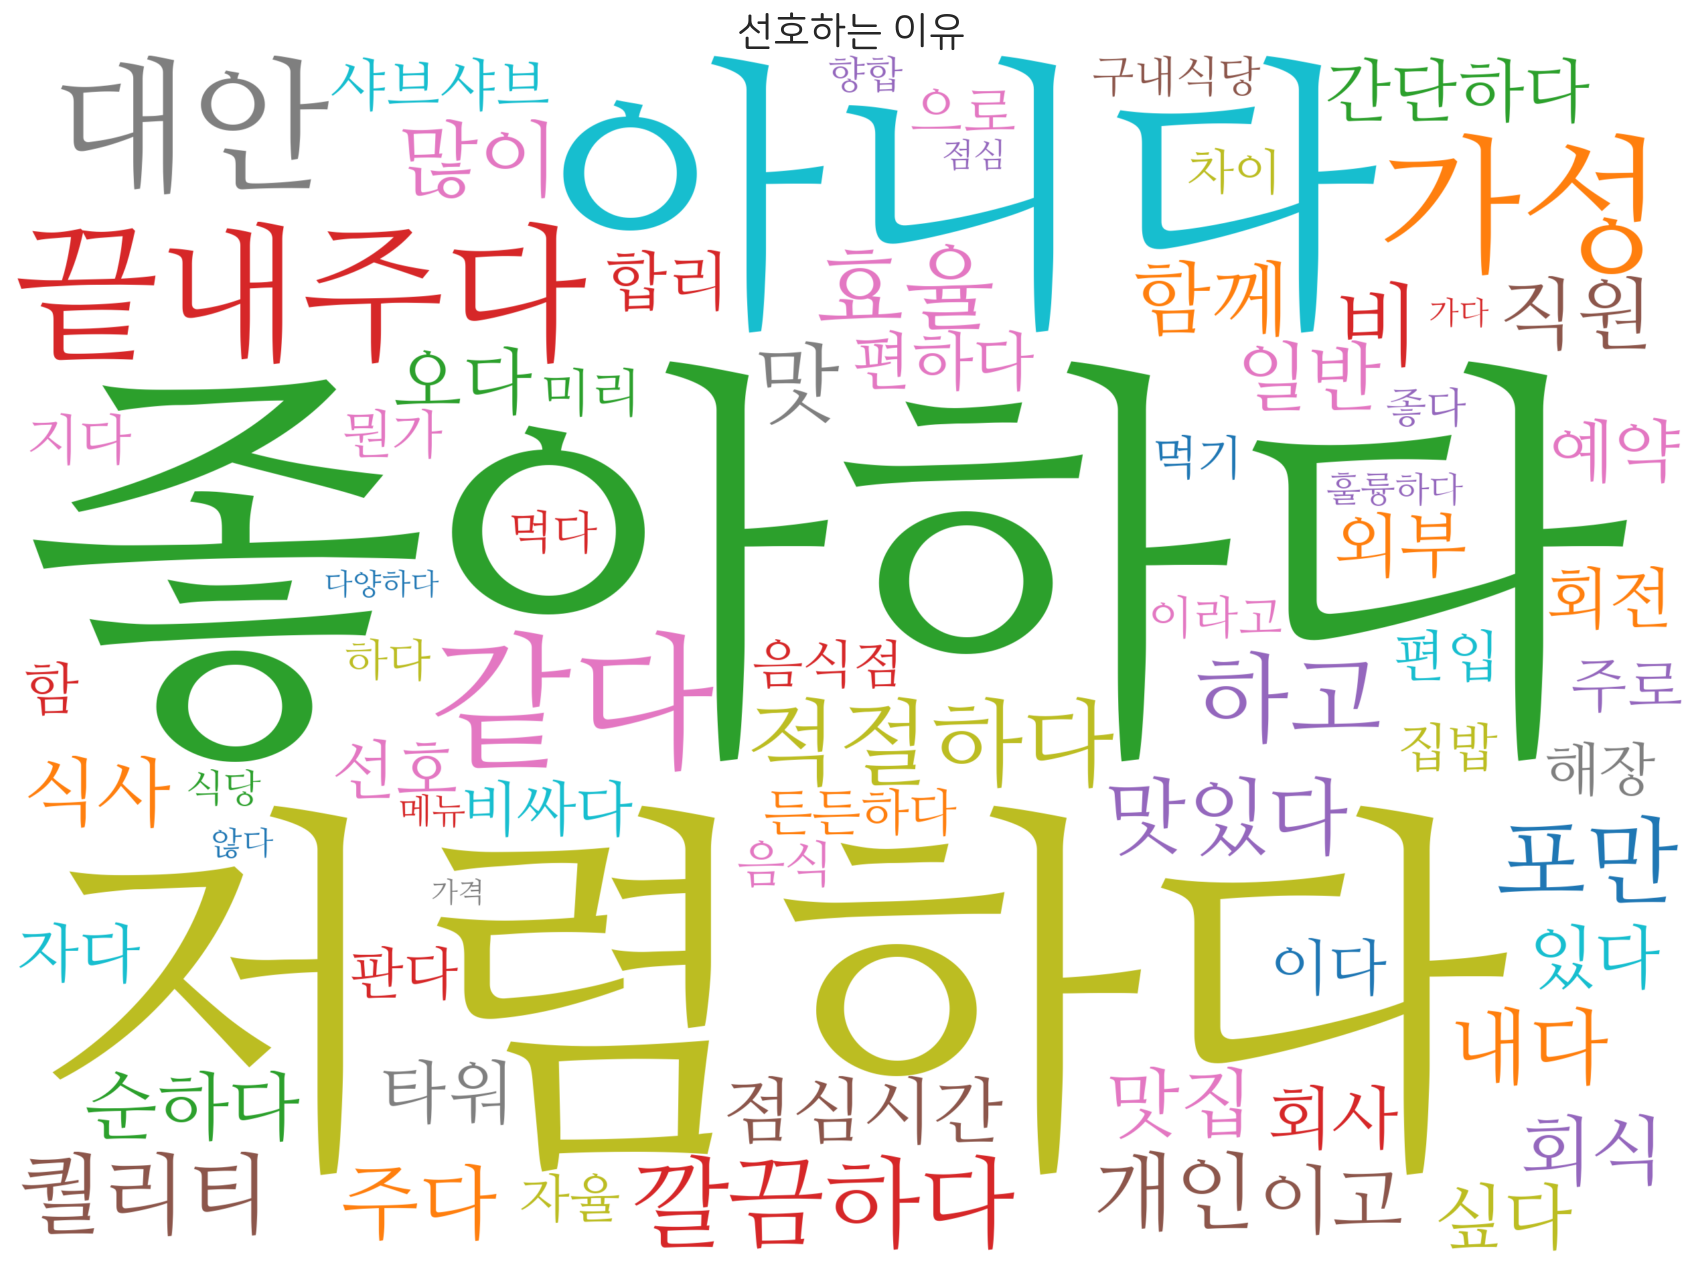

In [ ]:
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  # max_words=10,
                  colormap='tab10',
                  prefer_horizontal=1.0,
                  font_path=font_path).fit_words(tfidf_od)

plt.figure(figsize = (15, 20)) 
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.title("선호하는 이유", size = 20) # 제목 지정

plt.show()

## n-grams

In [ ]:
def to_trigrams(row):
  bigram = gensim.models.Phrases(row, delimiter=b' ')
  trigram = gensim.models.Phrases(bigram[row], delimiter=b' ')  
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram_mod = gensim.models.phrases.Phraser(trigram)
  bigrammed = bigram_mod[row]
  trigrammed = trigram_mod[bigrammed]
  
  return trigrammed

In [ ]:
df=pd.read_excel('/content/re_NH_Survey.xlsx',index_col=0)
df

,성별,연령대,구내식당 이용빈도,구내식당 선호 메뉴,선호하는 외부식당,선호하는 이유
0,남,40대,2~3회,감성집밥(한식),"1:청년다방,2:칭메이,3:택이네",1:가깝다...
1,여,40대,0~1회,샐러드,"1:명태골,2:고봉민김밥,3:포베이",1:좋아하는 메뉴이기도 하고 주문 후 늦지 않게 음식이 나오며 나름의 합리적인 가격...
2,남,40대,4~5회,감성집밥(한식),"1:개성샤브샤브,2:택이네..칼국수,3:정직한한우곰탕",1:국물이 끝내줍니다.
3,남,40대,4~5회,감성집밥(한식),"1:개성샤브샤브,2:전주콩나물국밥,3:없음",1:맛있음
4,남,40대,4~5회,감성집밥(한식),"1:진사골순대국,2:인덕원비빔국수,3:조이마루","1:해장, 맛"
...,...,...,...,...,...,...
59,남,50대,4~5회,감성집밥(한식),"1:동편옥,2:정감회식탁,3:전주명가콩나물국",1:회식 후 해장 등 간단히 단품으로 먹을 수 있는 국물있는 음식입니다
60,남,50대,4~5회,감성집밥(한식),"1:김치찌개,2:짜장면,3:부대찌개",NaN
61,남,50대,4~5회,감성집밥(한식),"1:월수금,2:은희네해장국,3:전주콩나물해장국",1:맛있고 저렴함
62,남,50대,4~5회,이국식탁(양식),"1:없음,2:없음,3:없음",1:없음


In [ ]:
def clean_content(content):
  cleaned = re.sub('[^가-힣ㄱ-ㅣa-zA-Z|.%]', ' ', string=str(content))
  cleaned = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', cleaned)
  return cleaned

df['선호하는 외부식당'] = df['선호하는 외부식당'].apply(clean_content)
df['선호하는 이유'] = df['선호하는 이유'].apply(clean_content)

df = df[['선호하는 외부식당','선호하는 이유']]
df

,선호하는 외부식당,선호하는 이유
0,청년다방 칭메이 택이네,가깝다
1,명태골 고봉민김밥 포베이,좋아하는 메뉴이기도 하고 주문 후 늦지 않게 음식이 나오며 나름의 합리적인 가격...
2,개성샤브샤브 택이네 칼국수 정직한한우곰탕,국물이 끝내줍니다
3,개성샤브샤브 전주콩나물국밥 없음,맛있음
4,진사골순대국 인덕원비빔국수 조이마루,해장 맛
...,...,...
59,동편옥 정감회식탁 전주명가콩나물국,회식 후 해장 등 간단히 단품으로 먹을 수 있는 국물있는 음식입니다
60,김치찌개 짜장면 부대찌개,nan
61,월수금 은희네해장국 전주콩나물해장국,맛있고 저렴함
62,없음 없음 없음,없음


In [ ]:
okt = Okt()
df = df['선호하는 이유'].apply(okt.morphs, stem=True)

In [ ]:
def oneWordRemoval(lst):
  for el in lst:
    if len(el) <= 1:
      lst.remove(el)

df.apply(oneWordRemoval)

0     None
1     None
2     None
3     None
4     None
      ... 
59    None
60    None
61    None
62    None
63    None
Name: 선호하는 이유, Length: 64, dtype: object

In [ ]:
## 불용어 사전
stop_words = '수, nan, 없다, P, 없음, 등, 않은, 이, 의, 있, 하, 것, 들, 그, 되, 보, 않, 없, 나, 주, 같, 때, 도, 을, 는, 가, 에, 햄버거'
stop_words =  stop_words.split(', ')

## 불용어 제거
def del_stop(data):
  words = []
  for w in data:
    if w not in stop_words:
      words.append(w)
  return words

df = df.apply(del_stop)

In [ ]:
df = df.apply(to_trigrams)

### TF-IDF 구축

In [ ]:
dictionary = gensim.corpora.Dictionary(df)
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in df]
tfidf = gensim.models.TfidfModel(BoW_corpus, smartirs='ntc')

In [ ]:
with open('tfidf.txt', 'wb') as f:
  pickle.dump(tfidf, f)

In [ ]:
num = 0
for doc in tfidf[BoW_corpus]:
  for id, freq in doc:
    num += 1

In [ ]:
tfidf_dic = {dictionary.get(id): freq for doc in tfidf[BoW_corpus] for id, freq in doc}

In [ ]:
toDataFrame = {
  '단어': tfidf_dic.keys(),
  '빈도': tfidf_dic.values(),    
}

pd.DataFrame(toDataFrame)

,단어,빈도
0,가깝다,0.125757
1,가격,0.062879
2,나름,0.324419
3,나오다,0.077091
4,늦다,0.324419
...,...,...
214,향합,0.125757
215,단축,0.433835
216,식사,0.433835
217,품,0.430251


In [ ]:
od = {v: k for k, v in tfidf_dic.items()}
ordered_keys = sorted(od.keys())
tfidf_od = {od[k]: k for k in ordered_keys}

In [ ]:
keys = list(tfidf_od.keys())
keys.reverse()
for i in range(50):
  key = keys[i]
  print(key, tfidf_od[key])

좋아하다 1.0
저렴하다 0.8479189970662935
아니다 0.8460950723820951
끝내주다 0.8320502943378437
가성 0.8294777680220412
같다 0.8245488444949856
대안 0.7970828348198792
깔끔하다 0.7670111260047169
하고 0.7369429459852567
적절하다 0.7071067811865476
포만 0.70387596995957
효율 0.6666666666666666
비 0.6149498878360499
퀄리티 0.592792445420739
맛 0.5865633082996418
개인 0.5411793619762352
맛있다 0.5301258099867343
내다 0.5141058278997058
많이 0.5124582398633749
주다 0.49438763600387137
함께 0.4924656486399595
직원 0.4714296925500057
식사 0.4338347278611111
회식 0.4302513084249362
일반 0.4283866231274176
맛집 0.42682876665775255
이고 0.4224410413841001
순하다 0.4170585901942225
점심시간 0.41038804053329964
오다 0.4102609580507703
싶다 0.395194963613826
외부 0.37985902932521726
타워 0.37350661603900737
있다 0.36436095674144175
예약 0.36152893988425927
간단하다 0.3585427570207802
회사 0.3569888526061813
회전 0.3383721589942232
선호 0.3283104324266397
합리 0.3244190967632902
편하다 0.31923276533270634
자다 0.3165491911043477
이다 0.28683420561662415
비싸다 0.28197679916185264
주로 0.26418959722907864


### 워드클라우드

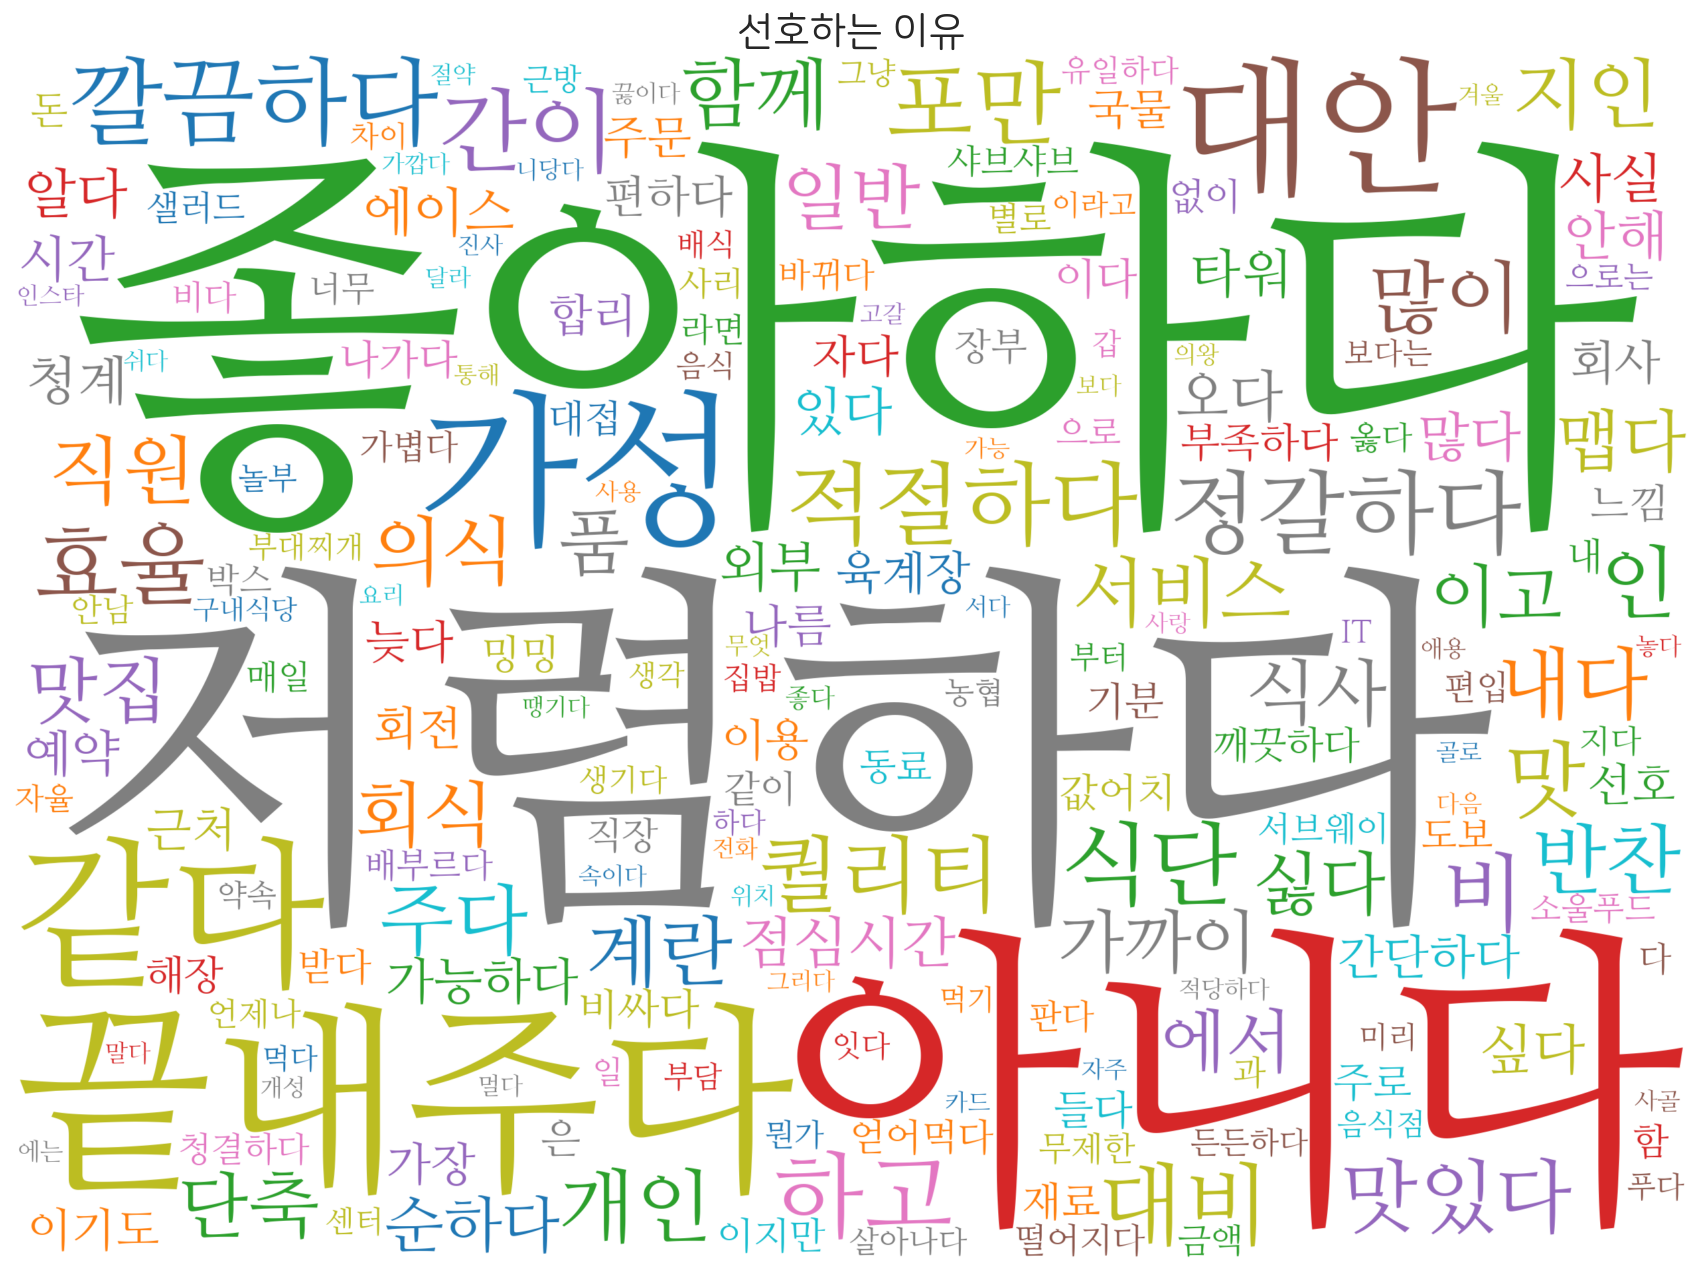

In [ ]:
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  # max_words=10,
                  colormap='tab10',
                  prefer_horizontal=1.0,
                  font_path=font_path).fit_words(tfidf_dic)

plt.figure(figsize = (15, 20)) 
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.title("선호하는 이유", size = 20) # 제목 지정

plt.show()

## LDA 토픽모델링

In [ ]:
from datetime import datetime
from time import time
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
num_topics = 4 # 토픽 수 설정
chunksize = 2000 # 한번에 처리할 row 수 설정
passes = 40 # 에폭 Number of passes through the corpus during training.
iterations = 400 # Maximum number of iterations through the corpus when inferring the topic distribution of a corpus.
eval_every = None # log 복잡도 계산 수행 유무 설정 1로 설정하면 학습이 2배로 느려짐
random_state = 100 # 재실행 시 같은 결과를 같기 위해 난수 설정

lda_model = gensim.models.ldamodel.LdaModel(corpus=tfidf[BoW_corpus],
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            chunksize=chunksize,
                                            passes=passes,
                                            iterations=iterations,
                                            random_state=random_state,
                                            eval_every=eval_every,)

In [ ]:
print(lda_model.print_topics())

[(0, '0.020*"좋아하다" + 0.017*"가격" + 0.016*"있다" + 0.015*"저렴하다" + 0.013*"가성" + 0.013*"같다" + 0.012*"메뉴" + 0.012*"다양하다" + 0.011*"하다" + 0.011*"포만"'), (1, '0.038*"가깝다" + 0.021*"식당" + 0.017*"선호" + 0.017*"하다" + 0.017*"좋다" + 0.017*"회사" + 0.015*"아니다" + 0.014*"가성" + 0.014*"대안" + 0.013*"식단"'), (2, '0.028*"메뉴" + 0.024*"깔끔하다" + 0.023*"다양하다" + 0.018*"편하다" + 0.015*"든든하다" + 0.013*"간이" + 0.013*"적절하다" + 0.013*"대비" + 0.013*"효율" + 0.011*"좋다"'), (3, '0.058*"맛있다" + 0.024*"좋다" + 0.020*"해장" + 0.015*"가성" + 0.013*"먹다" + 0.012*"있다" + 0.012*"이다" + 0.011*"하다" + 0.011*"가다" + 0.011*"간단하다"')]


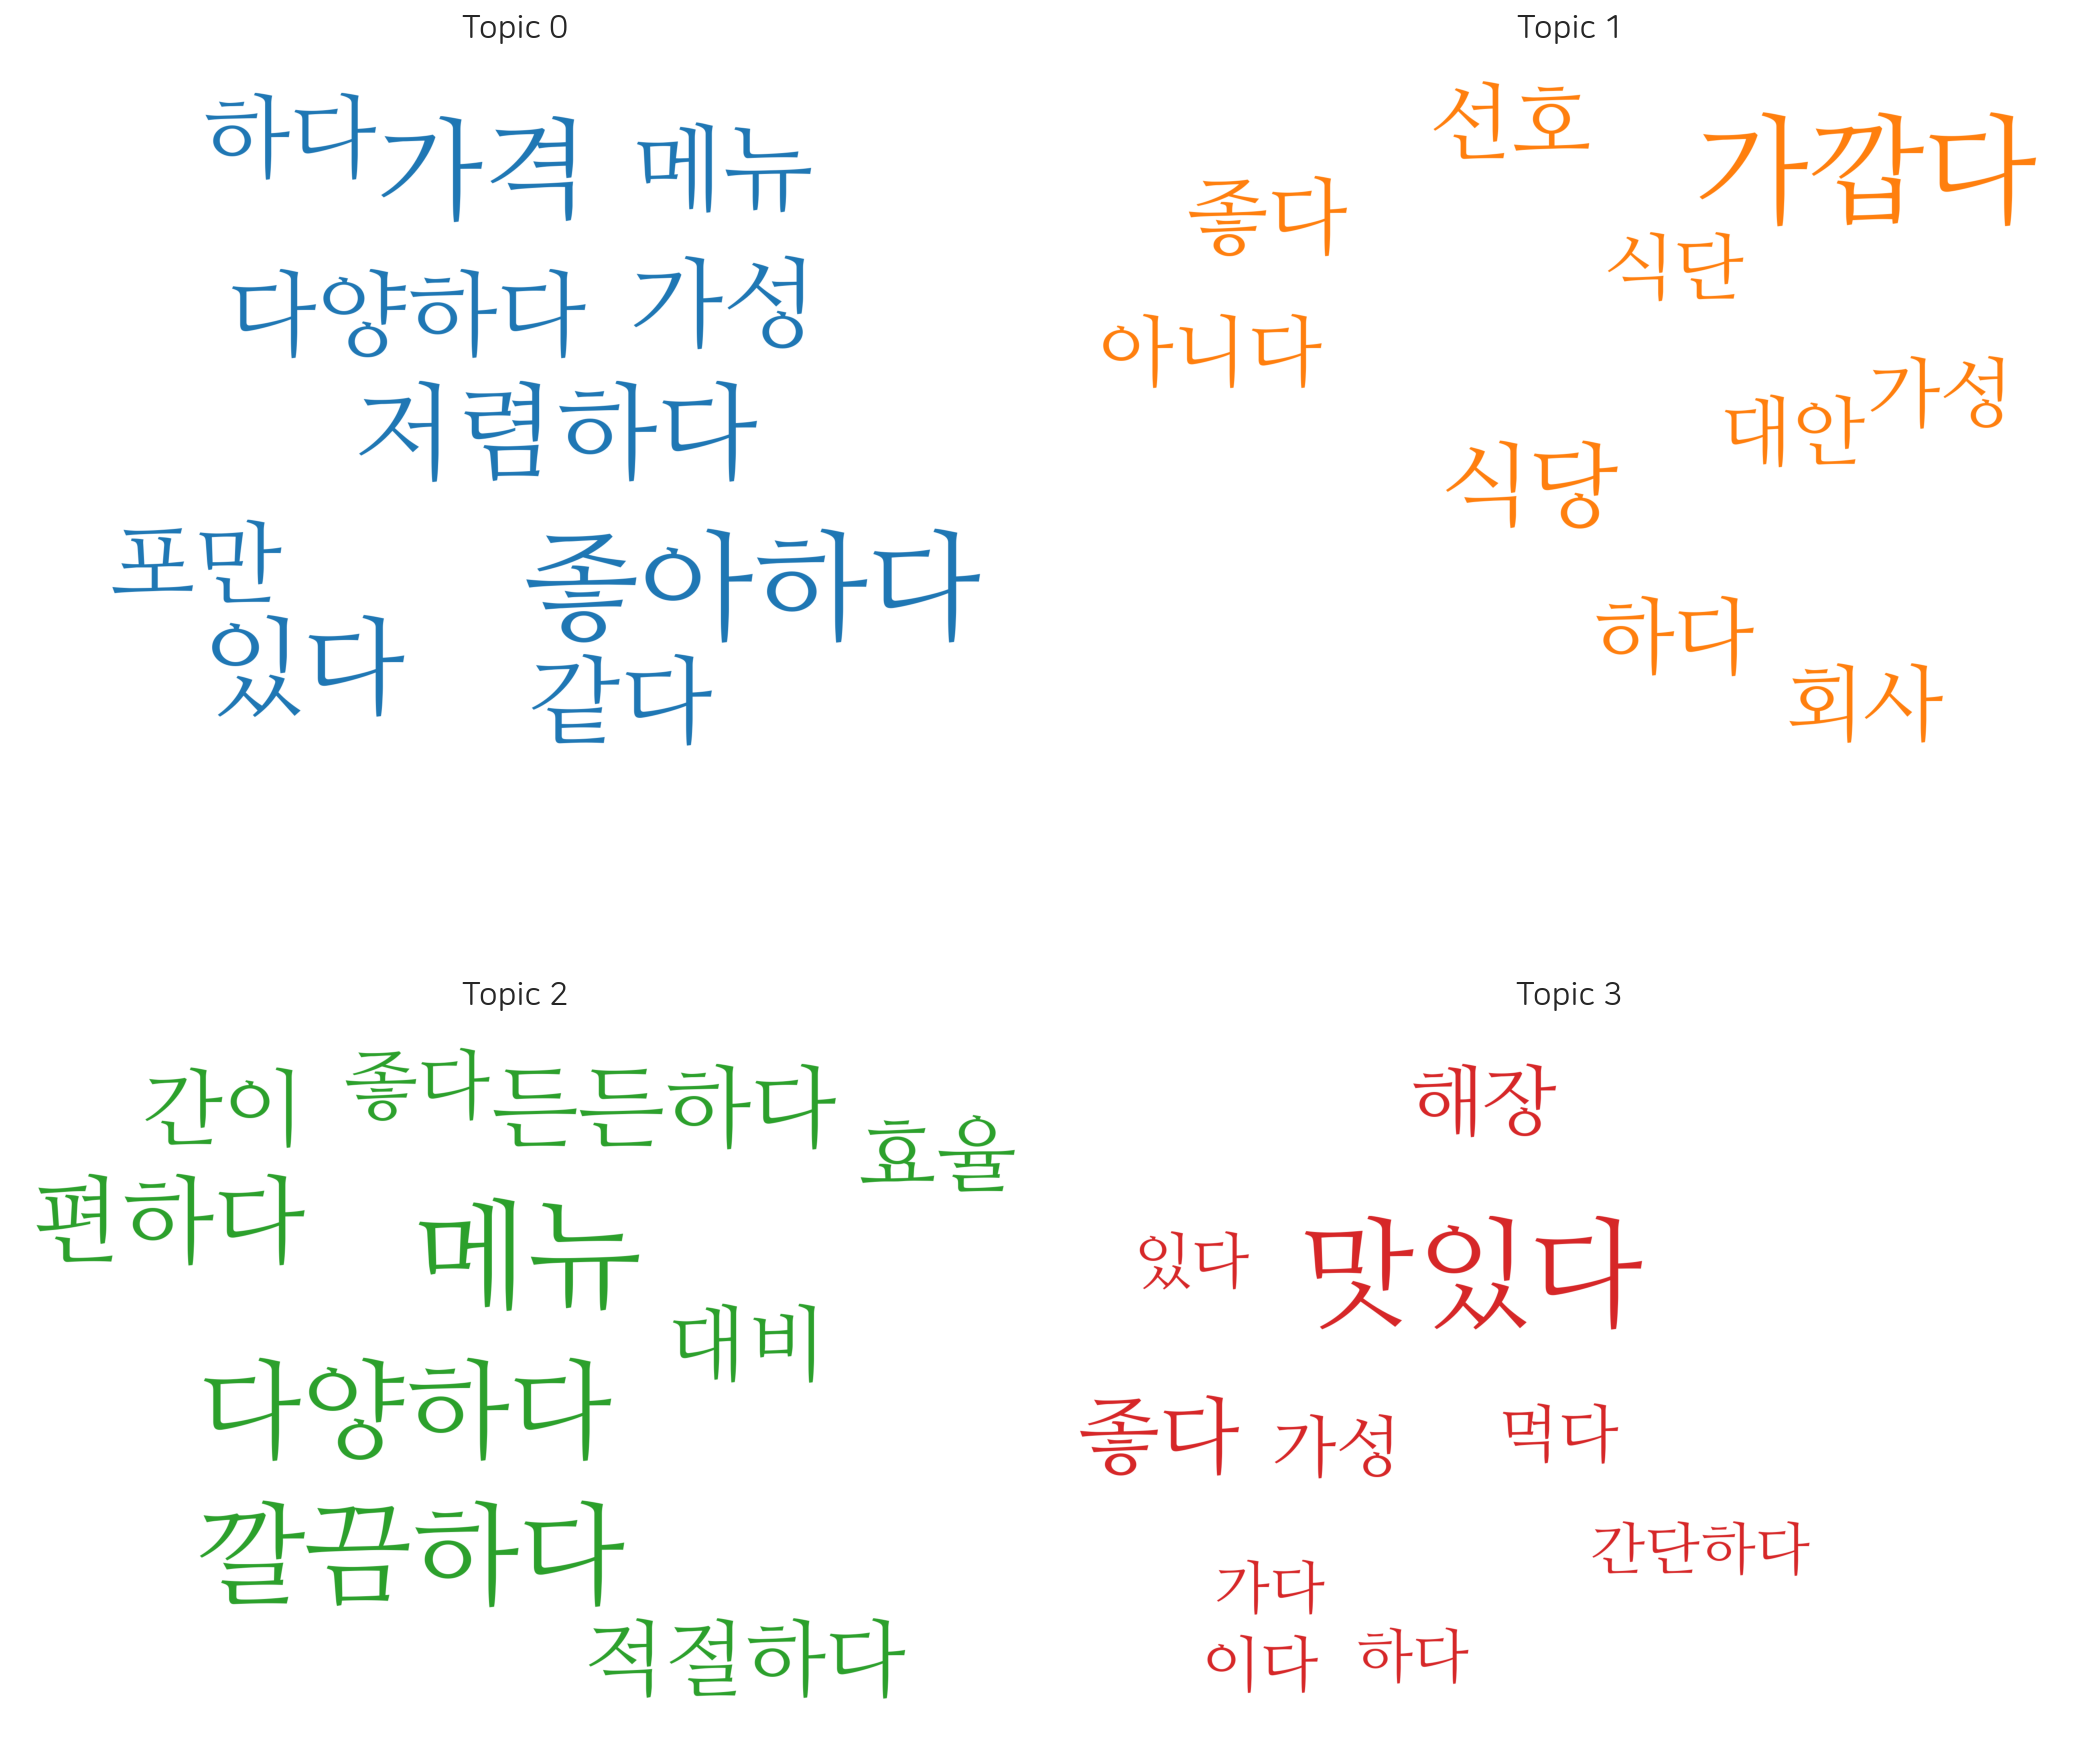

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0,
                  font_path=font_path)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, tfidf[BoW_corpus], dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.048939  0.013721       1        1  41.337737
0      0.019532  0.011546       2        1  24.573005
1      0.001571 -0.043758       3        1  18.247379
2      0.027837  0.018491       4        1  15.841879, topic_info=    Term      Freq     Total Category  logprob  loglift
0    가깝다  1.000000  1.000000  Default  30.0000  30.0000
18   맛있다  3.000000  3.000000  Default  29.0000  29.0000
59  깔끔하다  0.000000  0.000000  Default  28.0000  28.0000
5     메뉴  1.000000  1.000000  Default  27.0000  27.0000
23  다양하다  1.000000  1.000000  Default  26.0000  26.0000
..   ...       ...       ...      ...      ...      ...
33    싶다  0.117989  0.698112   Topic4  -5.1212   0.0647
1     가격  0.157596  0.951409   Topic4  -4.8317   0.0446
47    좋다  0.215661  2.069731   Topic4  -4.5181  -0.4190
30    먹다  0.130069  1.130437   Topic4  -5.0237  -0.3198
40    있다  0.128727  1.338364   Topic4  -5.0341  -0.4990

[183 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1         2  1.051072    가격
0         3  0.747907   가깝다
25        1  1.199323    가다
26        1  0.642774    가성
134       1  1.271249  간단하다
50        1  1.325403    개인
16        1  1.150472    국물
18        1  0.880544   맛있다
30        1  0.884614    먹다
5         4  0.741359    메뉴
8         1  0.907799    음식
76        1  1.063432    이다
40        1  0.747181    있다
24        1  0.874769  저렴하다
47        1  0.483155    좋다
12        2  0.852398  좋아하다
14        1  0.688286    하다
19        1  0.714673    해장, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])